### Example: Moving-Horizon Simulataneous Input-and-State Estimation
In this example, we consider a discrete-time linear time-invariant (LTI) system of the form:

$$
\begin{align*}
x_{k+1} &= Ax_k + Bu_k + w_k \\
y_k &= Cx_k + v_k
\end{align*}
$$
with
- $x_k \in \mathbb{R}^n$ represents the system state at time step $k$,
- $u_k \in \mathbb{R}^m$ is the control input at time step $k$,
- $y_k \in \mathbb{R}^p$ is a vector of measured outputs at time step $k$,
- $w_k \in \mathbb{R}^n$ and $v_k \in \mathbb{R}^p$ are process and measurement noise, respectively,
- $A \in \mathbb{R}^{n \times n}$, $B \in \mathbb{R}^{n \times m}$, and $C \in \mathbb{R}^{p \times n}$ are system matrices describing the dynamics and observation model.

The following simultaneous input and state estimation problem is solved:
$$
\begin{aligned}
    &\underset{x, u}{\mathrm{minimize}} \quad \sum_{n=k-N}^{k} u_n^T Q_u^{-1} v_v + \sum_{n=k-N}^{k} v_n^T Q_v^{-1} v_n + \sum_{n=k-N}^{k} w_n^T Q_w^{-1} w_n \\
    &\text{subject to} \\
    &x_{n} = A x_{n-1} + B u_{n-1} + w_n, &\quad n = k-N, \dots, k \\
    &y_n = C x_n + v_n, &\quad n = k-N, \dots, k \\
    &x_0 = \hat{x}_{k-N-1|k-N-1} \\
    &|u| \leq 1,
\end{aligned}
$$
where $Q_v \in \mathbb{R}^{p \times p}$, $Q_w \in \mathbb{R}^{n \times n}$, and $Q_u \in \mathbb{R}^{n \times n}$ are covariance matrices of $v_k$, $w_k$, and $u_k$, respectively.

**Define the system parameters**

In [1]:
import numpy as np
import cvxpy as cp
from scipy.linalg import expm, sqrtm, inv
from mh_sise.model_utils import lumped_mass_parameters

### EDIT THESE PARAMETERS ###
BATCH_LENGTH = 100
HORIZON_LENGTH = 100  # Horizon length
N_MASSES = 2  # Number of masses

# Example parameters
inertia, stiffness, damping = lumped_mass_parameters(
    N=N_MASSES, 
    length=1 * N_MASSES, 
    d_inner=1E-3, 
    d_outer=1.2E-3, 
    density=7850, 
    G=80E9, 
    damping_ratio=0.001, 
    natural_frequency=10
)

# Covariance matrices for noise (assumed zero-mean Gaussian noise)
Q_v = np.diag(np.array([1E-2, 1E-5]))  # Measurement noise covariance
Q_w = 0.01 * np.eye(N_MASSES * 2 - 1)  # Process noise covariance
Q_u = 1 * np.eye(2)  # Input noise covariance

ts = 0.001  # Sampling time (s)

# compile cvxgen code?
COMPILE = False

#############################


In [2]:
# System dimensions
n = 2 * N_MASSES - 1  # Number of states
m = 2  # Number of inputs
p = 2  # Number of outputs
c = 2 * m  # Number of constraints

# Parameters for mass, stiffness, and damping
I = inertia * np.ones(N_MASSES)
K = stiffness * np.ones(N_MASSES - 1)
C = damping * np.ones(N_MASSES - 1)

# Friction damping
D = np.zeros(N_MASSES)
D[0] = 0.1  # Example friction damping for the first mass

# Print system parameters
print('Mass moment of inertia:', inertia, 'kg·m²')
print('Stiffness coefficient:', stiffness, 'N·m/rad')
print('Damping coefficient:', damping, 'N·m/(rad/s)')

Mass moment of inertia: 3.3095736127772373e-09 kg·m²
Stiffness coefficient: 0.008432034682234997 N·m/rad
Damping coefficient: 0.00010851061025499141 N·m/(rad/s)


**Convert to state-space model**

< ADD FIGURE HERE >

In [3]:
from mh_sise.model_utils import lumped_mass_ss
from scipy.signal import cont2discrete

# contonuous-time model
Ac, Bc, Cc, Dc = lumped_mass_ss(N_MASSES=N_MASSES, I=I, K=K, C=C, D=D, sensor_loc=0)

# Discrete-time model
dsys = cont2discrete((Ac, Bc, Cc, Dc), ts, method='zoh')
Ad, Bd, Cd, Dd, dt_discrete = dsys

**Simulate**

In [4]:
from scipy.signal import dlsim
from mh_sise.model_utils import mexican_hat

n_states, n_inputs = np.shape(Bd)
n_outputs = np.shape(Cd)[0]

#initialize signals
hat_width = 5
usim = np.zeros([BATCH_LENGTH, n_inputs])
usim[:,0] = 0.5 * mexican_hat(BATCH_LENGTH, hat_width, BATCH_LENGTH/2)
usim[:,1] = mexican_hat(BATCH_LENGTH, hat_width, BATCH_LENGTH/4) + mexican_hat(BATCH_LENGTH, hat_width, 3/4*BATCH_LENGTH)

tsim, ysim, xsim = dlsim((Ad, Bd, Cd, Dd, dt_discrete), usim)

# Add measurement noise
v = np.random.multivariate_normal(np.zeros(Q_v.shape[0]), Q_v, BATCH_LENGTH)
ysim += v 

**Plot data**

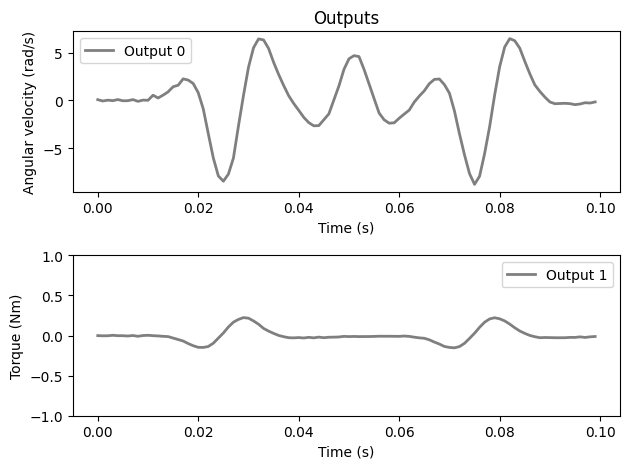

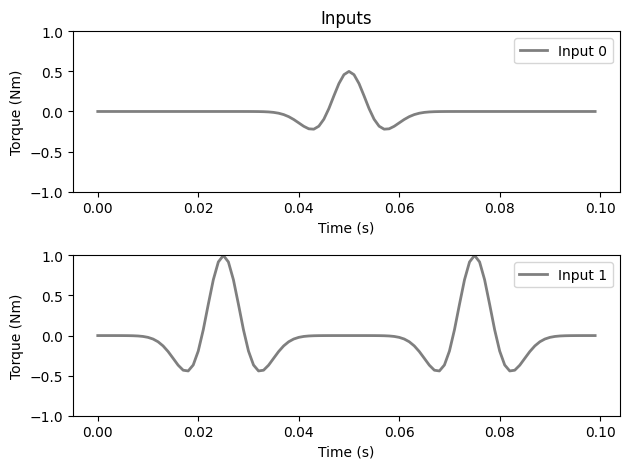

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(n_outputs)
# First subplot
axs[0].plot(tsim, ysim[:,0].T, 'k', alpha=0.5, linewidth=2, label=f'Output 0')
axs[0].legend()
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Angular velocity (rad/s)')
axs[0].set_title('Outputs')
# Second subplot
axs[1].plot(tsim, ysim[:,1].T, 'k', alpha=0.5, linewidth=2, label=f'Output 1')
axs[1].legend()
axs[1].set_ylim([-1, 1])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Torque (Nm)')
# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Create subplots
fig2, axs2 = plt.subplots(2)
# First subplot
axs2[0].plot(tsim, usim[:,0].T, 'k', alpha=0.5, linewidth=2, label=f'Input 0')
axs2[0].set_ylim([-1, 1])
axs2[0].legend()
axs2[0].set_xlabel('Time (s)')
axs2[0].set_ylabel('Torque (Nm)')
axs2[0].set_title('Inputs')
# Second subplot
axs2[1].plot(tsim, usim[:,1].T, 'k', alpha=0.5, linewidth=2, label=f'Input 1')
axs2[1].set_ylim([-1, 1])
axs2[1].legend()
axs2[1].set_xlabel('Time (s)')
axs2[1].set_ylabel('Torque (Nm)')
# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


**Define problem**

The problem is reformulated to ensure that it is compliant with [Disciplined Parametrized Programming]((https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming)) (DPP), which is a standard for specifying parameterised convex optimization problems in tools like CVXPY. A DPP-complient reformulation of the problem is 

$$
\begin{aligned}
    &\underset{X, U, V, W}{\mathrm{minimize}} \quad \| Q_u^{-1/2} U \|_2^2 + \| Q_v^{-1/2} V \|_2^2 + \| Q_w W \|_2^2 \\
    &\text{subject to} \\
    &X_{:,1:N} = AX_{:,:N-1} + BU \\
    &Y = CX + V \\
    &W_{:,1:} = X_{:,1:N} - AX_{:,:N-1} - BU, \\
    &W_{:,0} = X_{:,0} - \hat{x}_0 \\
    &|U| \leq 1,
\end{aligned}
$$
The subscript notation (e.g., $X_{:,1:N}$ and $X_{:,:N-1}$) works the same way as Python slicing conventions to refer to specific portions of matrices.

In [6]:
tsim = tsim.T
ysim = ysim.T
xsim = xsim.T

#- define variables
X = cp.Variable((n, HORIZON_LENGTH), name='X')
U = cp.Variable((m, HORIZON_LENGTH-1), name='U')
V = cp.Variable((p, HORIZON_LENGTH), name='V')
W = cp.Variable((n, HORIZON_LENGTH), name='W')

# define parameters
Q_v_inv_sqrt = cp.Parameter((p, p), name='Q_v_inv_sqrt')
Q_w_inv_sqrt = cp.Parameter((n, n), name='Q_w_inv_sqrt')
Q_u_inv_sqrt = cp.Parameter((m, m), name='Q_u_inv_sqrt')
y = cp.Parameter((p,HORIZON_LENGTH), name='y')
x0 = cp.Parameter(n, name='x0')
u0 = cp.Parameter(n, name='u0')
A = cp.Parameter((n,n), name='A')
B = cp.Parameter((n,m), name='B')
C = cp.Parameter((p,n), name='C')

# define objective
objective = cp.Minimize(
    cp.sum_squares( Q_w_inv_sqrt@W ) + cp.sum_squares( Q_v_inv_sqrt@V ) + cp.sum_squares( Q_u_inv_sqrt@U )  
)

#dpp (diciplined programming principle) check
print(objective.is_dcp(dpp=True))

# define constraints
constraints = [
    W[:,0] == X[:,0] - x0,
    W[:,1:] == X[:,1:HORIZON_LENGTH] - A@X[:,0:HORIZON_LENGTH-1] - B@U,
    V[:,:HORIZON_LENGTH] == y[:,:HORIZON_LENGTH] - C@X[:,:HORIZON_LENGTH],
    cp.abs(U) <= 1
]

# define problem
problem = cp.Problem(objective, constraints)

True


**Solve problem**
The problem is first solved using `cvxpy`.

In [7]:
import time

# assign cvx parameter values
Q_v_inv_sqrt.value = sqrtm( inv(Q_v) )
Q_w_inv_sqrt.value = sqrtm( inv(Q_w) )
Q_u_inv_sqrt.value = sqrtm( inv(Q_u) )
A.value = Ad
B.value = Bd
C.value = Cc
x0.value = np.zeros(n)
x0.value = np.zeros(n)
y.value = ysim

# solve
t0 = time.time()
solution = problem.solve(eps_abs=1e-3, eps_rel=1e-3, max_iter=4000, polish=False)
t1 = time.time()

print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % solution)


CVXPY
Solve time: 32.007 ms
Objective function value: 13.846132



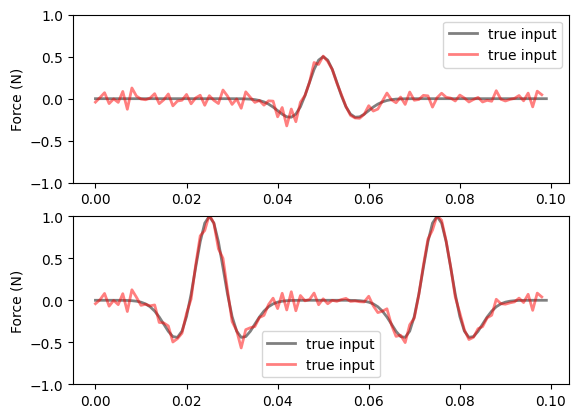

In [8]:
import matplotlib.pyplot as plt

# plot result
fig, axs = plt.subplots(2)
axs[0].plot(tsim, usim[:,0],'k', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(tsim[:-1], U.value[0,:].T,'r', alpha=0.5, linewidth=2, label='true input')
axs[0].set_ylabel('Force (N)')
axs[0].set_ylim([-1, 1])
axs[0].legend()

axs[1].plot(tsim,usim[:,1].T,'k', alpha=0.5, linewidth=2, label='true input')
axs[1].plot(tsim[:-1], U.value[1,:].T,'r', alpha=0.5, linewidth=2, label='true input')
axs[1].set_ylabel('Force (N)')
axs[1].set_ylim([-1, 1])
axs[1].legend()

**cvxgen**

In [9]:
from cvxpygen import cpg

if COMPILE:
    cpg.generate_code(problem, code_dir='codegen/sise_test')

In [10]:
from codegen.sise_test.cpg_solver import cpg_solve
import numpy as np
import pickle
import time

# load the serialized problem formulation
with open('codegen/sise_test/problem.pickle', 'rb') as f:
    prob = pickle.load(f)

# assign parameter values
prob.param_dict['Q_v_inv_sqrt'].value = sqrtm( inv(Q_v) )
prob.param_dict['Q_w_inv_sqrt'].value = sqrtm( inv(Q_w) )
prob.param_dict['Q_u_inv_sqrt'].value = sqrtm( inv(Q_u) )
prob.param_dict['A'].value = Ad
prob.param_dict['B'].value = Bd
prob.param_dict['C'].value = Cc
prob.param_dict['x0'].value = np.zeros(n)
#prob.param_dict['u0'].value = np.zeros(n)
prob.param_dict['y'].value = ysim

# solve problem conventionally
t0 = time.time()
# CVXPY chooses eps_abs=eps_rel=1e-5, max_iter=10000, polish=True by default,
# however, we choose the OSQP default values here, as they are used for code generation as well
val = prob.solve(eps_abs=1e-3, eps_rel=1e-3, max_iter=4000, polish=False)
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)

# solve problem with C code via python wrapper
prob.register_solve('CPG', cpg_solve)
t0 = time.time()
val = prob.solve(method='CPG')
t1 = time.time()
print('\nCVXPYgen\nSolve time: %.3f ms' % (1000 * (t1 - t0)))
print('Objective function value: %.6f\n' % val)


CVXPY
Solve time: 38.009 ms
Objective function value: 13.846132


CVXPYgen
Solve time: 8.002 ms
Objective function value: 13.879657

